<a href="https://colab.research.google.com/github/bendavidsteel/trade-democratization/blob/master/trade_diffusion_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch==1.5.1+cu101 torchvision==0.6.1+cu101 -f https://download.pytorch.org/whl/torch_stable.html
!pip install torch-scatter==2.0.4+cu101 -f https://pytorch-geometric.com/whl/torch-1.5.0.html
!pip install torch-sparse==0.6.5+cu101 -f https://pytorch-geometric.com/whl/torch-1.5.0.html
!pip install torch-cluster==1.5.5+cu101 -f https://pytorch-geometric.com/whl/torch-1.5.0.html
!pip install torch-spline-conv==1.2.0+cu101 -f https://pytorch-geometric.com/whl/torch-1.5.0.html
!pip install torch-geometric

Looking in links: https://download.pytorch.org/whl/torch_stable.html
Looking in links: https://pytorch-geometric.com/whl/torch-1.5.0.html
     |████████████████████████████████| 12.3MB 2.3MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.5.0.html
     |████████████████████████████████| 21.6MB 1.2MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.5.0.html
     |████████████████████████████████| 22.0MB 6.1MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.5.0.html
     |████████████████████████████████| 6.3MB 2.1MB/s 
     |████████████████████████████████| 174kB 2.8MB/s 
     |████████████████████████████████| 235kB 7.6MB/s 
     |████████████████████████████████| 2.1MB 8.7MB/s 
     |████████████████████████████████| 51kB 6.4MB/s 
  Created wheel for torch-geometric: filename=torch_geometric-1.6.0-cp36-none-any.whl size=296339 sha256=6cd80acc91aef894cf52ed3afc4e46ac5d0e1cc38084a4f9a44ff658aa68d144
  Stored in directory: /root/.cache/pip/whe

In [2]:
import itertools
import math
import os
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch_geometric as geo
import tqdm

from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
def get_mapping(vdem_nodes, tradhist_timevar):   

    vdem_country_codes = list(vdem_nodes['country_text_id'].unique())
    tradhist_country_codes = list(tradhist_timevar['iso_o'].unique())
    shared_codes = [code for code in vdem_country_codes if code in tradhist_country_codes]

    mapped_codes = [['RUS', 'USSR'], ['YEM', 'ADEN'], ['CAF', 'AOFAEF', 'FRAAEF'], ['TCD', 'AOFAEF', 'FRAAEF'], ['COD', 'AOFAEF', 'FRAAEF'], ['HRV', 'AUTHUN', 'YUG'], ['SVK', 'CZSK', 'AUTHUN'], 
                ['SVN', 'AUTHUN', 'YUG'], ['UKR', 'AUTHUN', 'USSR'], ['ALB', 'AUTHUN'], ['BIH', 'AUTHUN', 'YUG'], ['MNE', 'AUTHUN', 'YUG'], ['CAN', 'CANPRINCED', 'CANQBCONT', 'NFLD'], 
                ['CZE', 'CZSK', 'AUTHUN'], ['DDR', 'EDEU'], ['MYS', 'FEDMYS', 'UNFEDMYS', 'GBRBORNEO'], ['BFA', 'FRAAOF'], ['GNQ', 'FRAAOF'], ['LUX', 'ZOLL'], 
                ['ZZB', 'ZANZ', 'GBRAFRI'], ['ZAF', 'ZAFTRA', 'ZAFORA', 'ZAFNAT', 'ZAPCAF', 'GBRAFRI'], ['MKD', 'YUG'], ['SRB', 'YUG'], ['POL', 'USSR'], ['COM', 'MYT'], ['ROU', 'ROM'], 
                ['MWI', 'RHOD', 'GBRAFRI'], ['ZMB', 'RHOD', 'GBRAFRI'], ['ZWE', 'RHOD', 'GBRAFRI'], ['SGP', 'STRAITS'], ['DEU', 'WDEU'], ['SML', 'GBRSOM', 'ITASOM'], ['GBR', 'ULSTER'], 
                ['RWA', 'RWABDI'], ['SOM', 'ITASOM'], ['MAR', 'MARESP'], ['FRA', 'OLDENB'], ['DNK', 'SCHLES'], ['LBN', 'SYRLBN', 'OTTO'], ['SYR', 'SYRLBN'], ['CYP', 'OTTO', 'GBRMEDI'], 
                ['TUR', 'OTTO'], ['STP', 'PRTAFRI'], ['AGO', 'PRTAFRI'], ['MOZ', 'PRTAFRI'], ['GNB', 'PRTWAFRI'], ['KHM', 'INDOCHI'], ['LAO', 'INDOCHI'], ['VNM', 'INDOCHI'], 
                ['ERI', 'ITAEAFRI', 'GBRAFRI'], ['TTO', 'GBRWINDIES'], ['SLE', 'GBRWAFRI'], ['GMB', 'GBRWAFRI'], ['TGO', 'GBRWAFRI'], ['EGY', 'OTTO'],
                ['PNG', 'GBRPAPUA'], ['MLT', 'GBRMEDI'], ['BGD', 'GBRIND'], ['BTN', 'GBRIND'], ['IND', 'GBRIND'], ['MDV', 'GBRIND'], ['NPL', 'GBRIND'], ['PAK', 'GBRIND'], 
                ['LKA', 'GBRIND'], ['CMR', 'GBRAFRI', 'FRAAFRI'], ['KEN', 'GBRAFRI'], ['SYC', 'GBRAFRI'], ['SDN', 'GBRAFRI'], ['UGA', 'GBRAFRI'], ['LSO', 'GBRAFRI'], 
                ['SWZ', 'GBRAFRI']]

    # validate my matches
    code_count = {}
    for codes in mapped_codes:
        matched_to_vdem = 0
        for code in codes:
            if len(code) == 3:
                if code in vdem_country_codes:
                    if code in code_count:
                        code_count[code] += 1
                    else:
                        code_count[code] = 1
                    matched_to_vdem += 1

        if matched_to_vdem == 0:
            raise ValueError("{} country code set matched to no VDem node".format(codes))
        elif matched_to_vdem > 1:
            raise ValueError("{} country code set matched to more than one VDem node".format(codes))

        if codes[0] not in vdem_country_codes:
            raise ValueError("VDem code should be first in list {}.".format(codes))

    for code in code_count:
        if code_count[code] != 1:
            raise ValueError("VDem code {} matched to more than one country code set".format(code))

    for code in shared_codes:
        if code not in code_count:
            mapped_codes.append([code])

    return mapped_codes

In [4]:
class Sequence():
    def __init__(self, initial, sequence, missing_mask, target):
        self.initial = initial
        self.sequence = sequence
        self.missing_mask = missing_mask
        self.target = target

    def to(self, device):
        self.initial = self.initial.to(device)
        self.missing_mask = self.missing_mask.to(device)
        self.target = self.target.to(device)
        for idx in range(len(self.sequence)):
            self.sequence[idx] = self.sequence[idx].to(device)
        return self

In [5]:
class RegressionGraphNet(torch.nn.Module):
    def __init__(self, num_node_features, num_edge_features, num_outputs):
        super(RegressionGraphNet, self).__init__()
        # we will use the edge conditioned convolution (NNConv) as this allows more than 1 edge feature
        # while also not requiring inputs to be scaled between 0 and 1

        hidden_layer_size = 5

        # NNConv requires a layer to transform the dimensionality of edge features to the required size
        lin1 = torch.nn.Linear(num_edge_features, num_node_features * hidden_layer_size)

        # arbitrarily using 16 as hidden layer size
        self.conv1 = geo.nn.NNConv(num_node_features, hidden_layer_size, lin1)
        self.lin1 = torch.nn.Linear(hidden_layer_size, num_outputs)

    def forward(self, data):
        # weights are by default floats
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr

        x = self.conv1(x, edge_index, edge_attr)
        x = torch.nn.functional.relu(x)
        x = torch.nn.functional.dropout(x, p=0.6, training=self.training)
        x = self.lin1(x)

        # final activation is linear as this is for regression
        return x

In [37]:
class RecurGraphNet(torch.nn.Module):
    def __init__(self, num_node_features, num_edge_features, num_output_features):
        super().__init__()

        conv_layer_size = 6
        lstm_layer_size = 6

        # graph convolutional layer to create graph representation
        conv_lin = torch.nn.Linear(num_edge_features, num_node_features * conv_layer_size)
        self.conv = geo.nn.NNConv(num_node_features, conv_layer_size, conv_lin)

        # lstm to learn sequential patterns
        self.lstm = torch.nn.LSTM(conv_layer_size, lstm_layer_size)

        # initial trainable hidden state for lstm
        self.lstm_h_s = torch.nn.Linear(num_output_features, lstm_layer_size)
        self.lstm_c_s = torch.nn.Linear(num_output_features, lstm_layer_size)

        # final linear layer to allow full expressivity for regression after tanh activation in lstm
        self.final_linear = torch.nn.Linear(lstm_layer_size, num_output_features)

    def forward(self, input):
        initial, sequence = input.initial, input.sequence
        
        # create graph representation
        graph_collection = []
        for idx in range(len(sequence)):
            x, edge_index, edge_attr = sequence[idx].x, sequence[idx].edge_index, sequence[idx].edge_attr
            graph_step = torch.nn.functional.relu(self.conv(x, edge_index, edge_attr))
            graph_collection.append(graph_step)
        # provide graph representations as sequence to lstm
        graph_series = torch.stack(graph_collection)

        # recurrent stage
        # initial state of lstm is representation of target prior to this sequence
        lstm_output, _ = self.lstm(graph_series, (self.lstm_h_s(initial).unsqueeze(0), self.lstm_c_s(initial).unsqueeze(0)))

        # final activation is relu as this is for regression and the metrics of this dataset are all positive
        return self.final_linear(lstm_output)

In [7]:
root = os.path.join('/', 'content', 'drive', 'My Drive', 'projects', 'trade_democratization')

# Read data into Data object.
vdem_nodes = pd.read_csv(os.path.join(root, "dataset", "raw", "V-Dem-CY-Core-v10.csv"))

tradhist_timevar_frames = []
for idx in range(1, 4):
    tradhist_timevar_frames.append(pd.read_excel(os.path.join(root, "dataset", "raw", "TRADHIST_GRAVITY_BILATERAL_TIME_VARIANT_{}.xlsx".format(idx))))
tradhist_timevar = pd.concat(tradhist_timevar_frames)

In [8]:
country_mapping = get_mapping(vdem_nodes, tradhist_timevar)

In [9]:
def full_sequence():
    dataset = torch.load(os.path.join(root, "dataset", "processed", 'traddem_series.pt'))

    seq_len = len(dataset) + len(dataset[-1].sequence) - 1
    num_countries = len(country_mapping)
    num_targets = 1

    initial = dataset[0].initial
    y = torch.zeros(seq_len, num_countries, num_targets, dtype=torch.float32)

    full_sequence = []
    for idx, seq in enumerate(dataset):
        full_sequence.append(seq.sequence[0])
        y[idx, :, :] = seq.target[0, :, :]

    for idx in range(1, len(dataset[-1].sequence)):
        full_sequence.append(dataset[-1].sequence[idx])
        y[len(dataset) + idx - 1, :, :] = dataset[-1].target[idx, :, :]

    non_recur_seq = []

    x = torch.zeros(num_countries, full_sequence[0].x.shape[1] + num_targets, dtype=torch.float32)
    x[:, :2] = full_sequence[0].x[:, :]
    x[:, 2] = initial[:, :].squeeze(-1)
    non_recur_seq.append(geo.data.Data(x=x, edge_index=full_sequence[0].edge_index, edge_attr=full_sequence[0].edge_attr))

    for idx in range(1, len(full_sequence)):
        x = torch.zeros(num_countries, full_sequence[idx].x.shape[1] + num_targets, dtype=torch.float32)
        x[:, :2] = full_sequence[idx].x[:, :]
        # non recurrent model will fill in the rest of the x vector as it iterates along years
        non_recur_seq.append(geo.data.Data(x=x, edge_index=full_sequence[idx].edge_index, edge_attr=full_sequence[idx].edge_attr))

    # offset of 1 for recurrent input to have the first prediction be on the same year for both models
    # provide stub values for missing_mask and targets as we don't need them here
    return non_recur_seq, Sequence(initial, full_sequence, torch.tensor(1), torch.tensor(1)), y

In [46]:
non_recur_seq, recur_seq, real_data = full_sequence()

In [47]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

num_node_features = 2
num_edge_features = 7
num_targets = 1

recur_model = RecurGraphNet(num_node_features, num_edge_features, num_targets)
recur_model = recur_model.to(device)
recur_model.load_state_dict(torch.load(os.path.join(root, 'best_model_recurrent.pkl')))

non_recur_model = RegressionGraphNet(num_node_features + num_targets, num_edge_features, num_targets)
non_recur_model = non_recur_model.to(device)
non_recur_model.load_state_dict(torch.load(os.path.join(root, 'best_model_non_recurrent.pkl')))

<All keys matched successfully>

In [48]:
@torch.no_grad()
def get_predictions(recur_seq, non_recur_seq):
    # get prediction of recurrent model
    recur_seq = recur_seq.to(device)
    recur_prediction = recur_model(recur_seq)

    # first data object in this sequence has prior demo conditions
    year_preds = []
    for idx in range(len(non_recur_seq)):
        data = non_recur_seq[idx].to(device)
        pred = non_recur_model(data)
        year_preds.append(pred)

        if idx + 1 < len(non_recur_seq):
            non_recur_seq[idx + 1].x[:, 2] = pred.squeeze(-1)

    non_recur_prediction = torch.stack(year_preds)

    return recur_prediction, non_recur_prediction

recur_prediction, non_recur_prediction = get_predictions(recur_seq, non_recur_seq)

Denormalize our results with the normalization stats from the original dataset

In [49]:
norm_stats = torch.load(os.path.join(root, "dataset", "processed", "norm_stats.pt"))

recur_prediction = (recur_prediction * norm_stats["y_std"]) + norm_stats["y_mean"]
non_recur_prediction = (non_recur_prediction * norm_stats["y_std"]) + norm_stats["y_mean"]
real_data = (real_data * norm_stats["y_std"]) + norm_stats["y_mean"]

Sanity check

In [50]:
print(recur_prediction.shape)
print(non_recur_prediction.shape)
print(real_data.shape)

torch.Size([114, 177, 1])
torch.Size([114, 177, 1])
torch.Size([114, 177, 1])


In [51]:
cty1 = "RUS"
cty2 = "DEU"
cty3 = "ITA"

node_dict = torch.load(os.path.join(root, "dataset", "processed", "node_dict.pt"))
years = []
for data in node_dict:
    years.append(data["year"])

for idx, cty_codes in enumerate(country_mapping):
    if cty1 in cty_codes:
        cty1_idx = idx
    if cty2 in cty_codes:
        cty2_idx = idx
    if cty3 in cty_codes:
        cty3_idx = idx

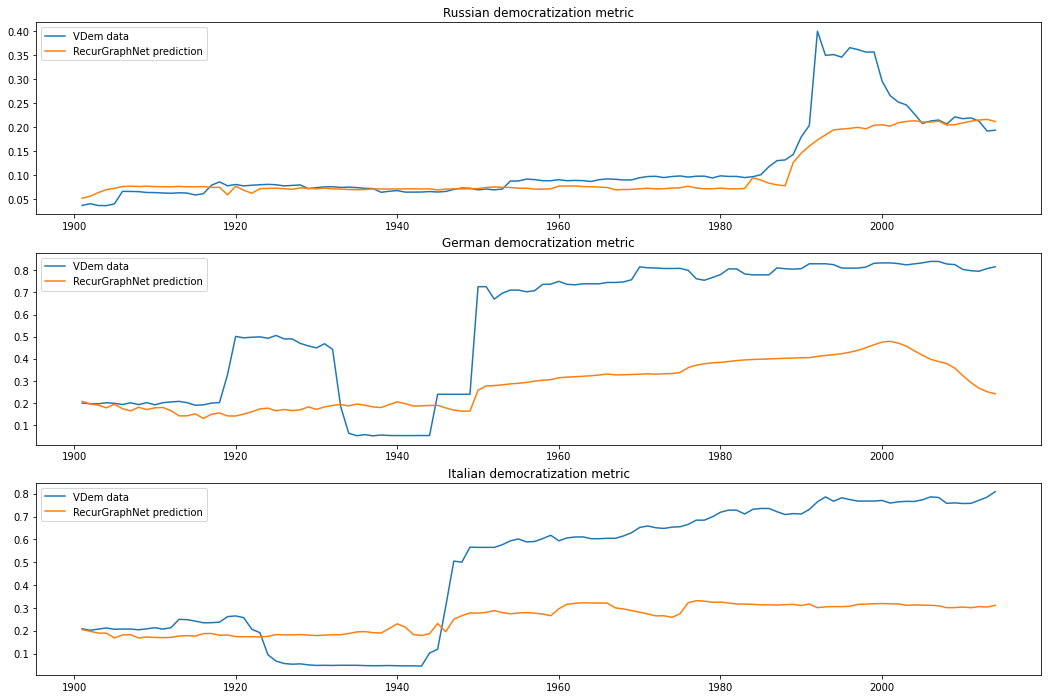

In [52]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, figsize=(18, 12))

ax1.plot(years, real_data[:, cty1_idx, 0], label="VDem data")
ax2.plot(years, real_data[:, cty2_idx, 0], label="VDem data")
ax3.plot(years, real_data[:, cty3_idx, 0], label="VDem data")

ax1.plot(years, recur_prediction[:, cty1_idx, 0], label="RecurGraphNet prediction")
ax2.plot(years, recur_prediction[:, cty2_idx, 0], label="RecurGraphNet prediction")
ax3.plot(years, recur_prediction[:, cty3_idx, 0], label="RecurGraphNet prediction")

#ax1.plot(years, non_recur_prediction[:, cty1_idx, 0], label="GraphNet prediction")
#ax2.plot(years, non_recur_prediction[:, cty2_idx, 0], label="GraphNet prediction")
#ax3.plot(years, non_recur_prediction[:, cty3_idx, 0], label="GraphNet prediction")

ax1.title.set_text("Russian democratization metric".format(cty1))
ax2.title.set_text("German democratization metric".format(cty2))
ax3.title.set_text("Italian democratization metric".format(cty3))

ax1.legend()
ax2.legend()
ax3.legend()

plt.show()